<a href="https://colab.research.google.com/github/eyalbd2/097215_Natural-Language-Processing_Workshop-Notebooks/blob/master/NLP_2_pytorch_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://img.icons8.com/dusk/64/000000/mind-map.png" style="height:50px;display:inline"> IE 097215 - Technion - Natural Language Processing

## Pytorch basics



### Part 1 - Tensors

Tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing.

In [ ]:
import torch

Initializing a tensor, with what is in memory at the moment.

In [ ]:
x = torch.empty(4, 4)
print(x)

And now lets initialize it randomly

In [ ]:
x = torch.rand(4, 4)
print(x)

Zeros tensor

In [ ]:
x = torch.zeros(5, 3, dtype=torch.long)
print(x)

Construct directly:

In [ ]:
x = torch.tensor([12.25, 2])
print(x)

We can create a tensor based on an existing tensor, and get its size. 

In [ ]:
x = x.new_ones(4, 4, dtype=torch.double)      # new_* methods take in sizes
print(x)

x = torch.randn_like(x, dtype=torch.float)    # override dtype!
print(x) 
x.size()

Lets watch some tensor oprations:

In [ ]:
# Addition
y = torch.rand(4, 4)
print("x+y = ")
print(x + y)

# Another addition
print("x+y = ")
print(torch.add(x, y))

# Addition in-place (changing y)
y.add_(x)
print("y = ")
print(y)


In [ ]:
# Numpy operations on Tensors
print(f"x=\n{x}")
print(f"x[0, :]={x[0, :]}")
print(f"x[:, 0]={x[:, 0]}")

Resizing and reshaping a tensor

In [ ]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, int(x.size(0)*2))  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

In [ ]:
x[0][0] = 5
print(x)
print(z)

Convert a tensor to a numpy array

In [ ]:
a = torch.ones(5)
print(a)

b = a.numpy()
print(b)

In [ ]:
# See how the numpy array changed in value.
a.add_(1)
print(a)
print(b)

Convert Numpy array to tensor

In [ ]:
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

### Cuda Tensors
Using the .to method, Tensors can be moved onto any device.

In [ ]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!

In [ ]:
# We could also move tensor to the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
torch.cuda.is_available()

See PyTorch Tensors [Tutorial](https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html) and [Documentation](https://pytorch.org/docs/stable/tensors.html) for more info and examples.

### Part 2 - Define a DNN model
We would like to demonstrate how to construct a simple regression model with pytorch. We devide this demonstration to 4 steps:


1.   Creating our neural-net model
2.   Data Creation and split to train, val, test
3.   Optimizer and Loss
4.   Training

Lets begin.. :)




#### Step 1 - Creating our neural-net model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# We create a FC regression network, with 2 layers.
class RegressioNet(nn.Module):
   def __init__(self):
       super(RegressioNet, self).__init__()
       self.hidden_dim = 10
       self.layer_1 = torch.nn.Linear(1, self.hidden_dim)
       self.layer_2 = torch.nn.Linear(self.hidden_dim, 1)
       self.activation = F.relu

   def forward(self, x):
       x = self.layer_1(x)        # x.size() -> [batch_size, self.hidden_dim]
       x = self.activation(x)     # x.size() -> [batch_size, self.hidden_dim]
       x = self.layer_2(x)        # x.size() -> [batch_size, 1]
       return x  

net = RegressioNet()
print(net)

RegressioNet(
  (layer_1): Linear(in_features=1, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


###### Activation Function
We are building a regression model, hence we don't need an activation function. However, an example of a ReLU implementation is given by [`F.relu`](https://pytorch.org/docs/stable/nn.functional.html#relu). 
Recall the ReLU formulation:
$ReLU(x) = max(0,x)$

#### Step 2 - Data Creation and split to train, val, test


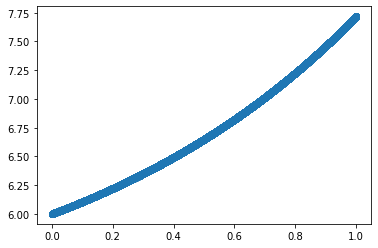

In [2]:
# Visualize our data
import matplotlib.pyplot as plt
import numpy as np

x = np.random.rand(100000)

# y = exp(x) + 5 + noise
y = np.exp(x) + np.random.rand(100000)*0.001 + 5

plt.scatter(x, y)
plt.show()

In [3]:
split_frac = 0.8

## split data into training, validation, and test data (x and y)

split_idx = int(len(x)*split_frac)
train_x, remaining_x = x[:split_idx], x[split_idx:]
train_y, remaining_y = y[:split_idx], y[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

# print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))



			Feature Shapes:
Train set: 		(80000,) 
Validation set: 	(10000,) 
Test set: 		(10000,)


#### Step 3 - Optimizer and Loss
Next, we should define the Optimizer and the Loss Function for our training process. We will use SGD as an optimizer,although many others are available (such as Adam, RMSprop, Adagrad..). Our Loss function will be is the MSE as we are constructiong a regression model (if we would build a classification model we would use Cross-Entropy).

In [4]:
# Define Optimizer and Loss Function
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

#### Step 4 - Training

In [5]:
batch_size = 20

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
valid_data = TensorDataset(torch.from_numpy(val_x).float(), torch.from_numpy(val_y).float())
test_data = TensorDataset(torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float())

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [6]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([20])
Sample input: 
 tensor([0.5117, 0.4086, 0.3768, 0.0191, 0.2792, 0.4746, 0.7216, 0.7271, 0.3383,
        0.2480, 0.3213, 0.1245, 0.1910, 0.3846, 0.4239, 0.3527, 0.6402, 0.9795,
        0.4566, 0.0351])

Sample label size:  torch.Size([20])
Sample label: 
 tensor([6.6686, 6.5054, 6.4586, 6.0200, 6.3230, 6.6080, 7.0577, 7.0699, 6.4030,
        6.2822, 6.3792, 6.1332, 6.2114, 6.4692, 6.5279, 6.4231, 6.8978, 7.6636,
        6.5792, 6.0360])


In [7]:
# First checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')


No GPU available, training on CPU.


In [8]:
# Define training params
epochs = 1 

counter = 0
print_every = 100
clip = 1000 # gradient clipping

# move model to GPU, if available
net = net.float()
net.to(device)

net.train()
# train for some number of epochs

RegressioNet(
  (layer_1): Linear(in_features=1, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)

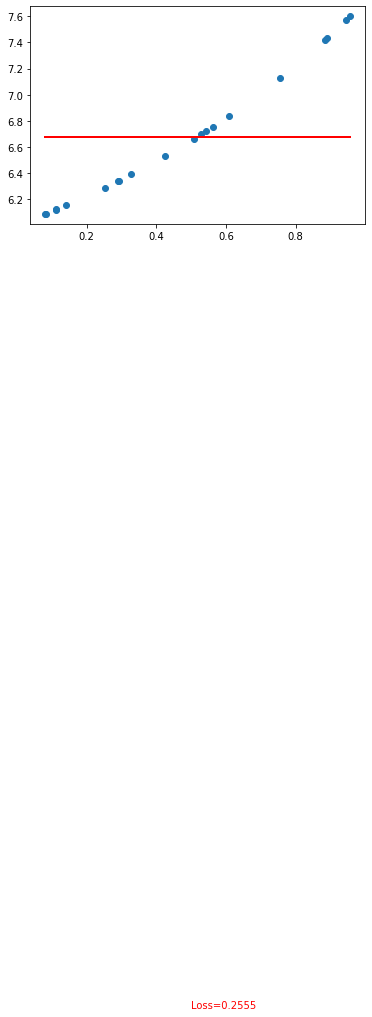

Epoch: 1/1... Step: 100... Loss: 0.148571... Val Loss: 0.241189


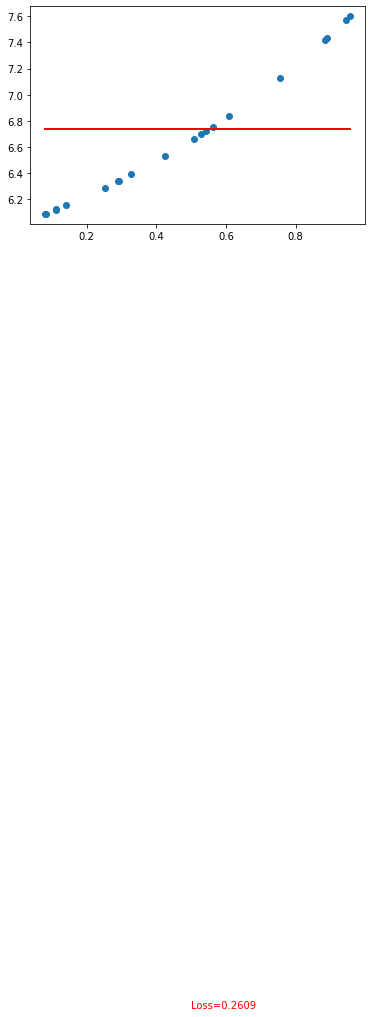

Epoch: 1/1... Step: 200... Loss: 0.267098... Val Loss: 0.239977


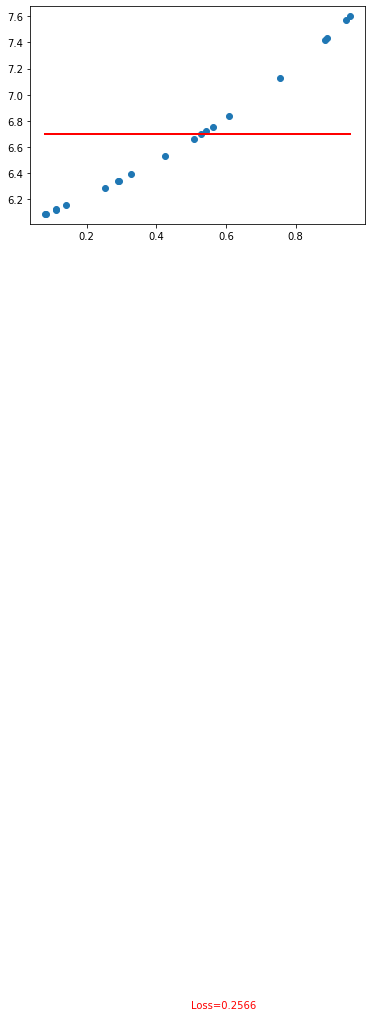

Epoch: 1/1... Step: 300... Loss: 0.294993... Val Loss: 0.239822


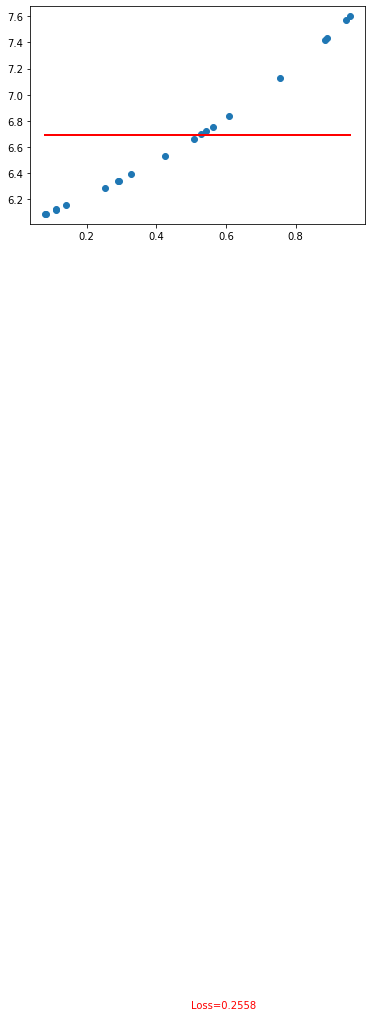

Epoch: 1/1... Step: 400... Loss: 0.268792... Val Loss: 0.240514


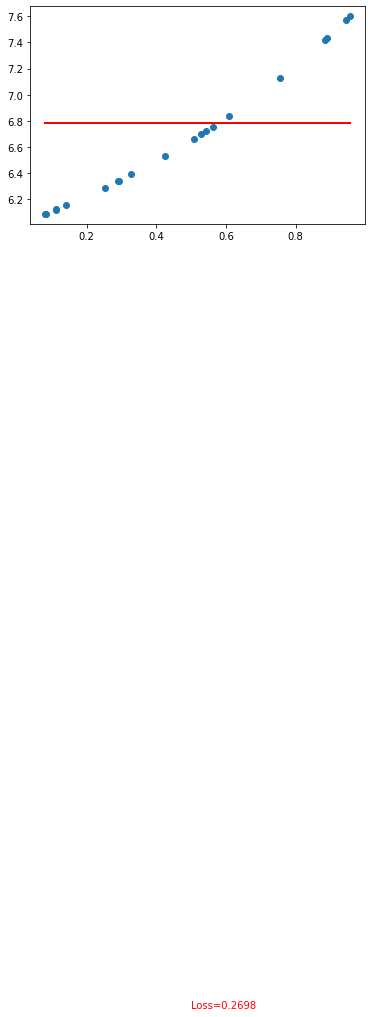

Epoch: 1/1... Step: 500... Loss: 0.191968... Val Loss: 0.243973


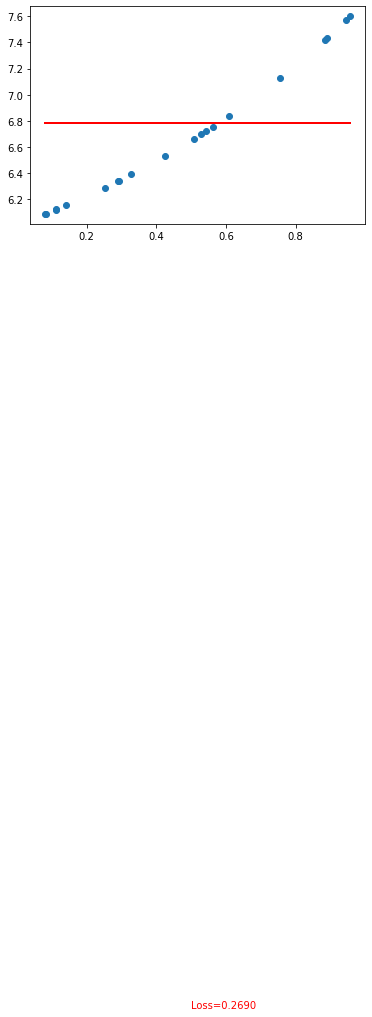

Epoch: 1/1... Step: 600... Loss: 0.301006... Val Loss: 0.243521


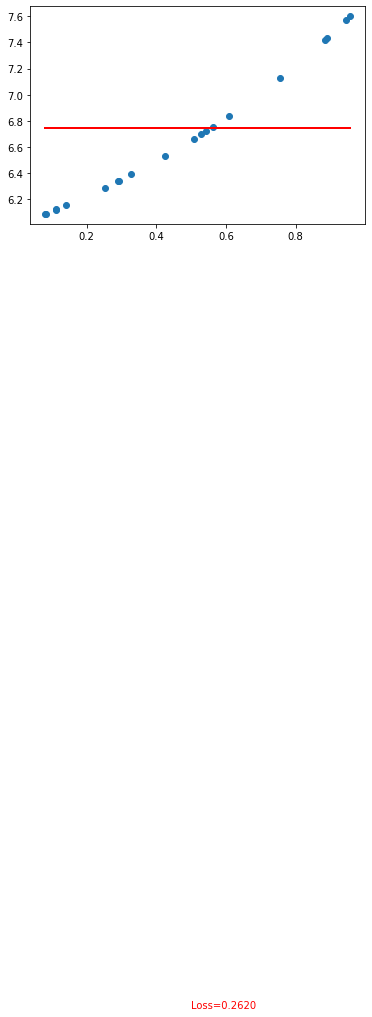

Epoch: 1/1... Step: 700... Loss: 0.160160... Val Loss: 0.240320


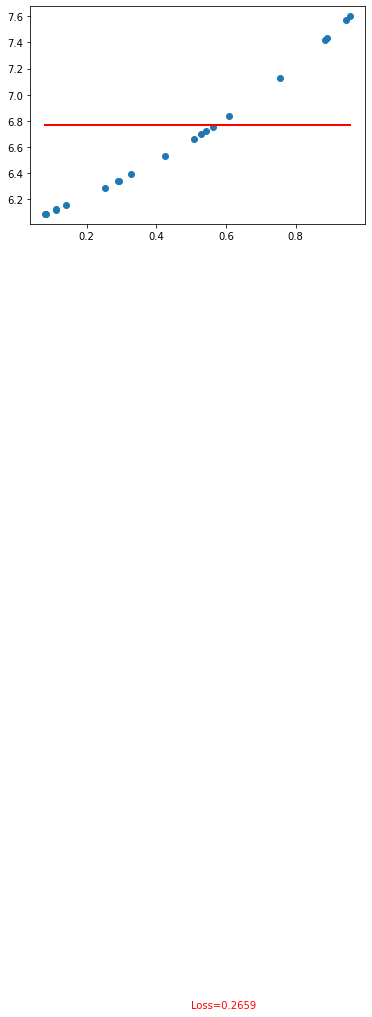

Epoch: 1/1... Step: 800... Loss: 0.240248... Val Loss: 0.241916


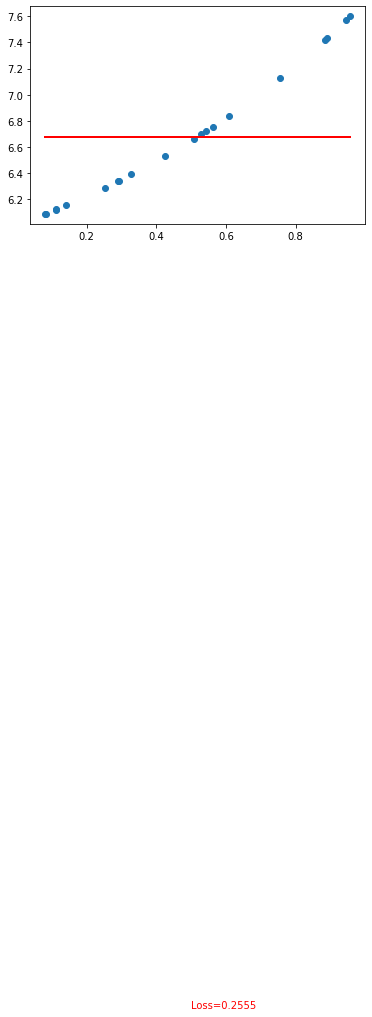

Epoch: 1/1... Step: 900... Loss: 0.302773... Val Loss: 0.241167


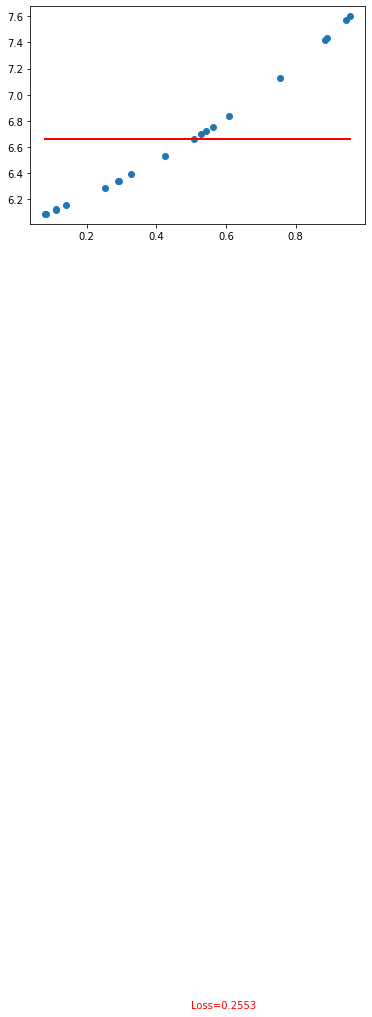

Epoch: 1/1... Step: 1000... Loss: 0.175387... Val Loss: 0.243261


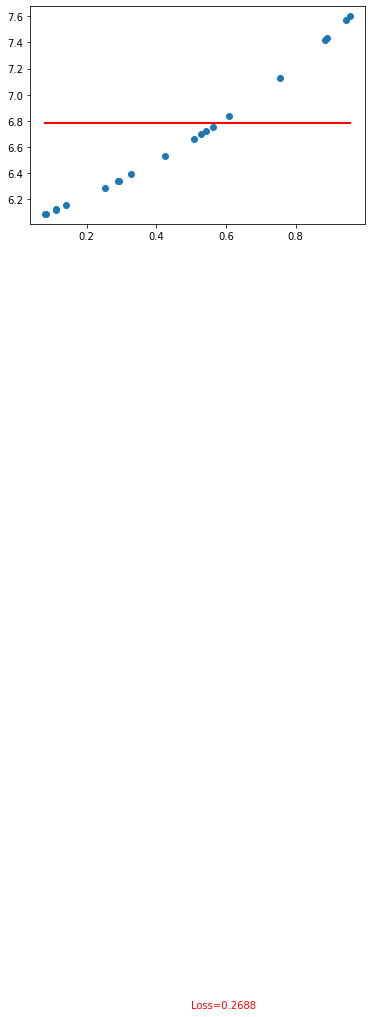

Epoch: 1/1... Step: 1100... Loss: 0.328289... Val Loss: 0.243398


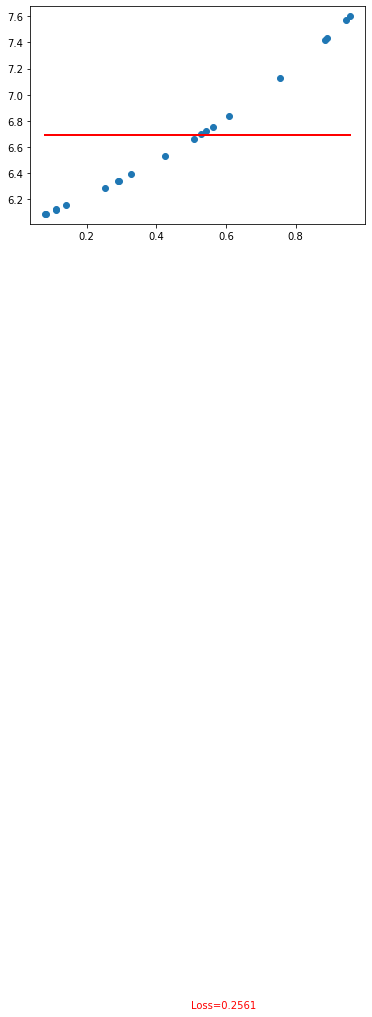

Epoch: 1/1... Step: 1200... Loss: 0.326258... Val Loss: 0.240154


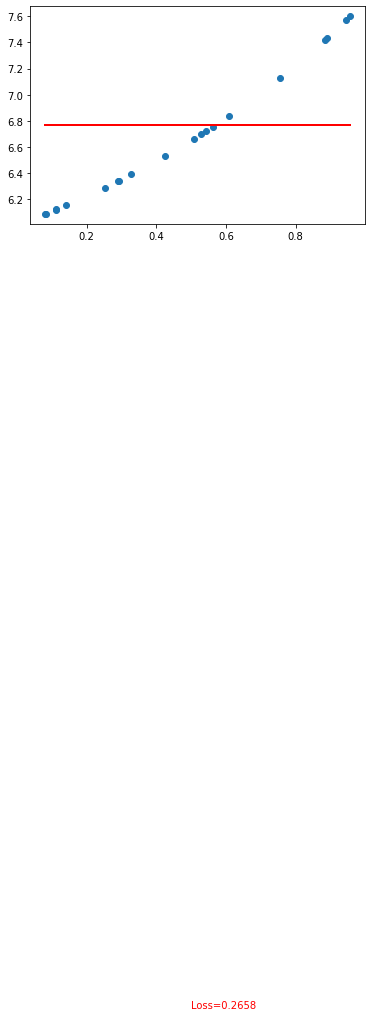

Epoch: 1/1... Step: 1300... Loss: 0.274477... Val Loss: 0.241884


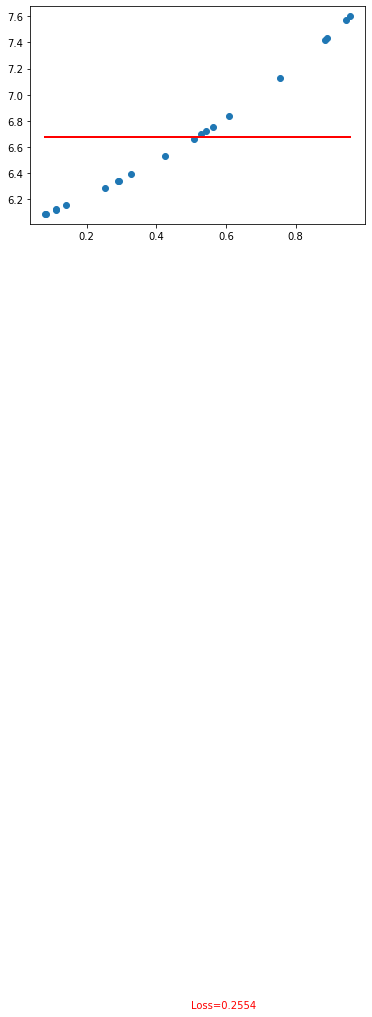

Epoch: 1/1... Step: 1400... Loss: 0.238445... Val Loss: 0.241214


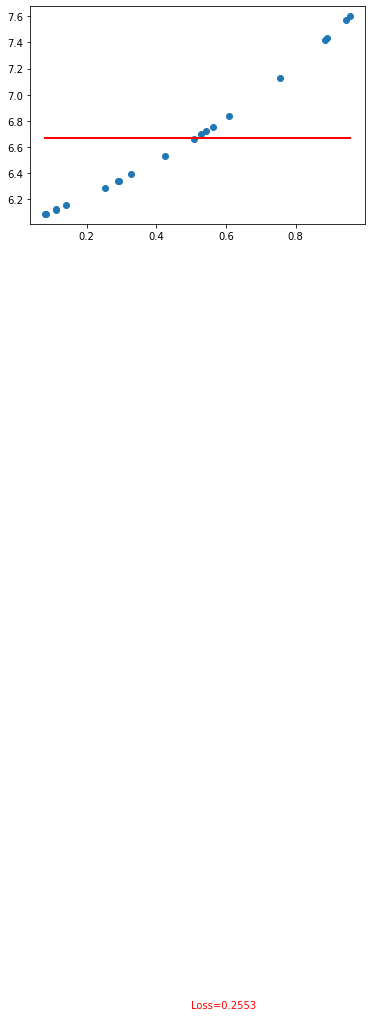

Epoch: 1/1... Step: 1500... Loss: 0.334831... Val Loss: 0.241938


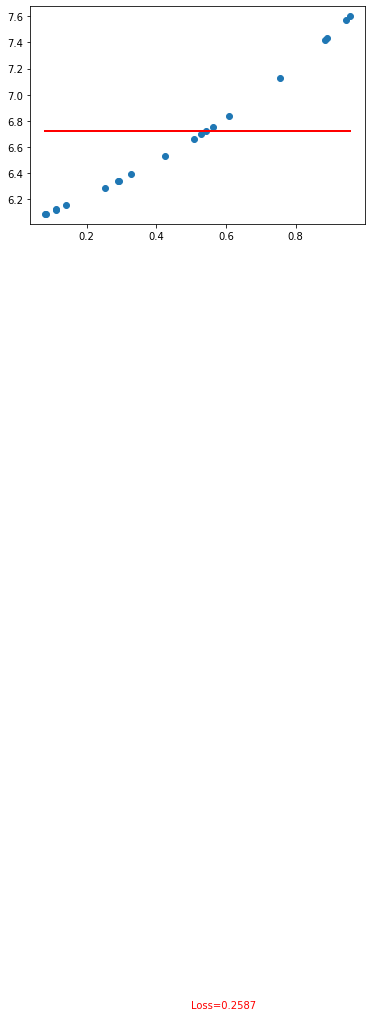

Epoch: 1/1... Step: 1600... Loss: 0.194239... Val Loss: 0.239554


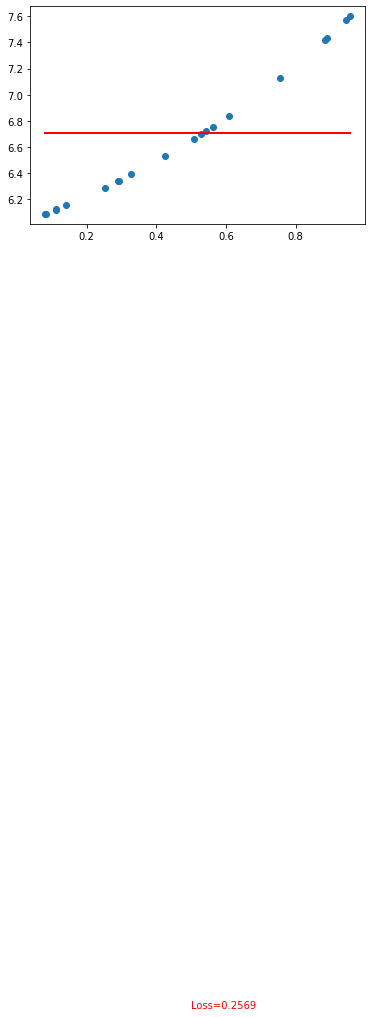

Epoch: 1/1... Step: 1700... Loss: 0.282896... Val Loss: 0.239716


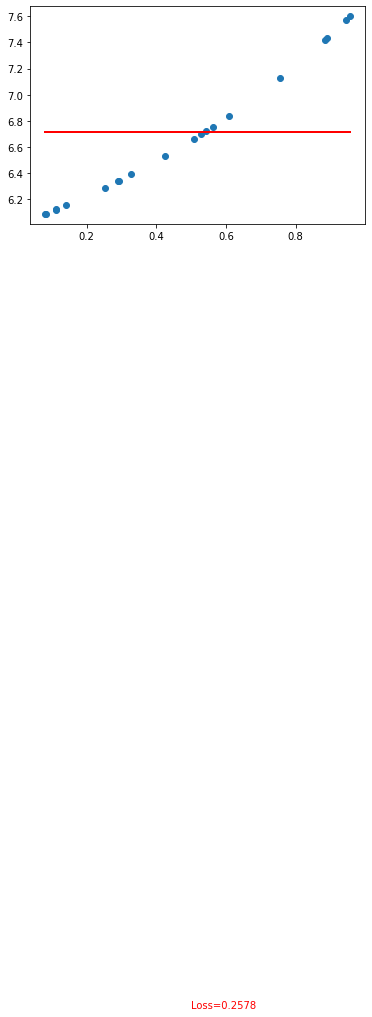

Epoch: 1/1... Step: 1800... Loss: 0.187647... Val Loss: 0.239544


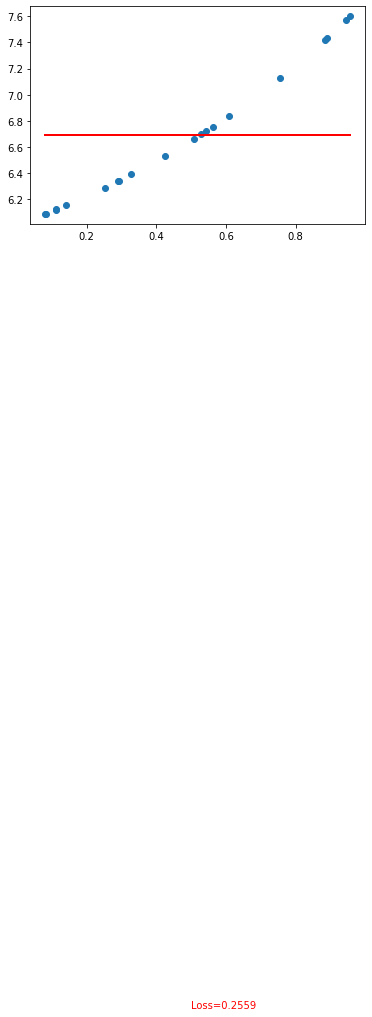

Epoch: 1/1... Step: 1900... Loss: 0.318679... Val Loss: 0.240338


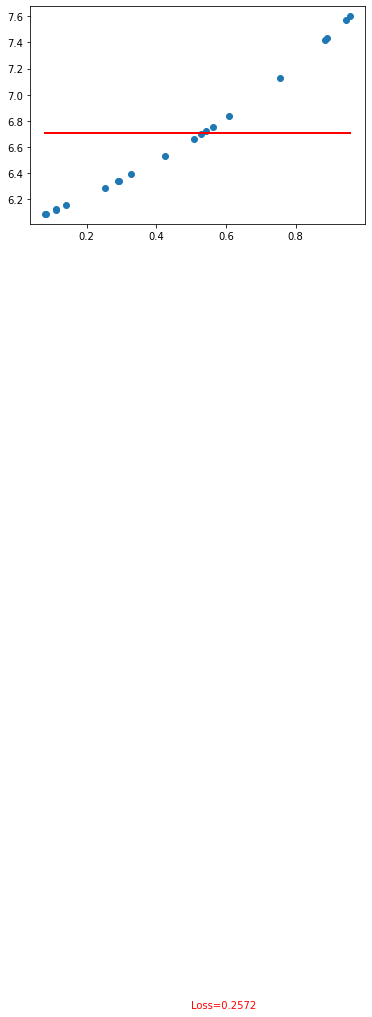

Epoch: 1/1... Step: 2000... Loss: 0.197600... Val Loss: 0.239635


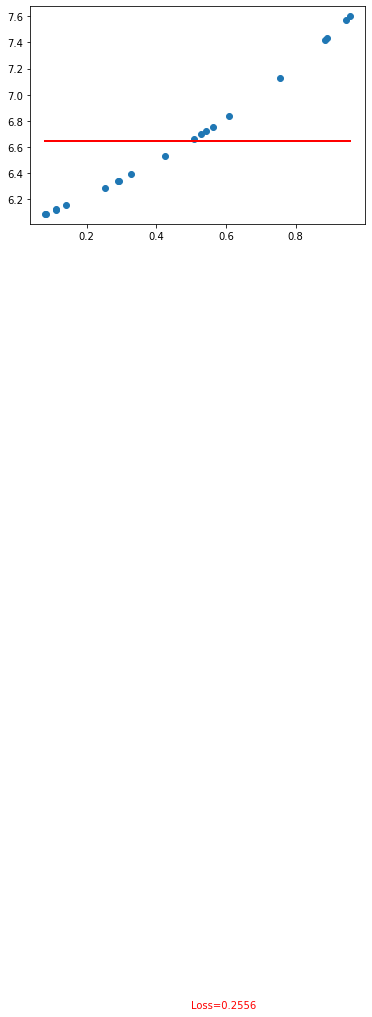

Epoch: 1/1... Step: 2100... Loss: 0.287579... Val Loss: 0.244892


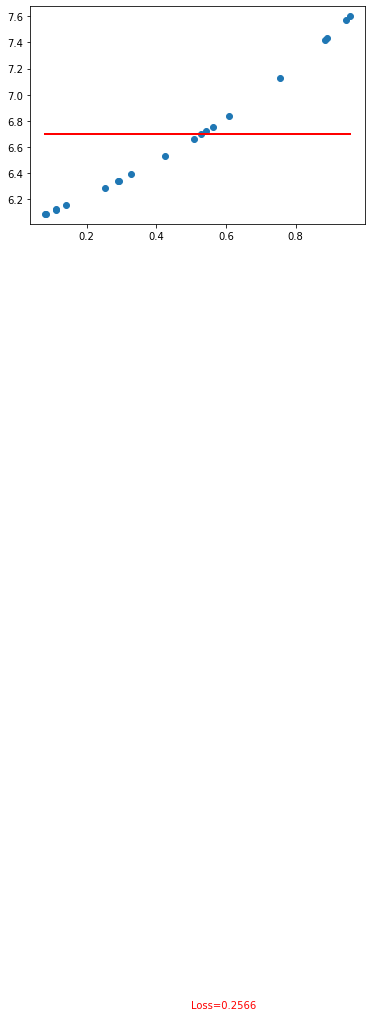

Epoch: 1/1... Step: 2200... Loss: 0.343466... Val Loss: 0.239846


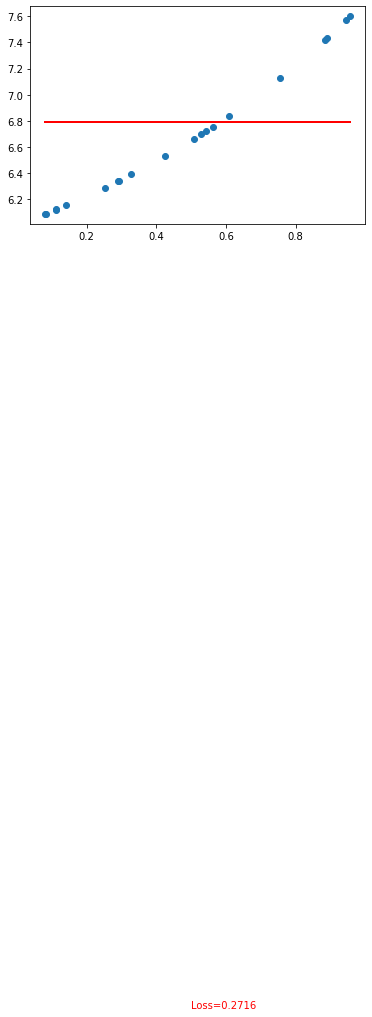

Epoch: 1/1... Step: 2300... Loss: 0.296468... Val Loss: 0.244946


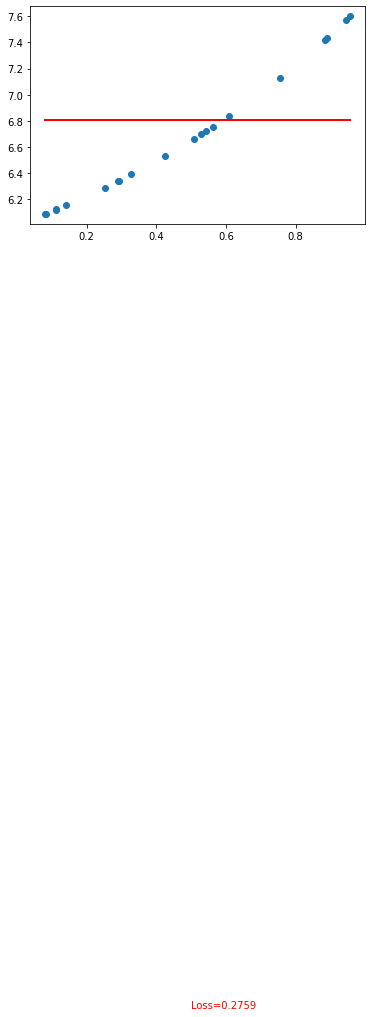

Epoch: 1/1... Step: 2400... Loss: 0.240078... Val Loss: 0.247535


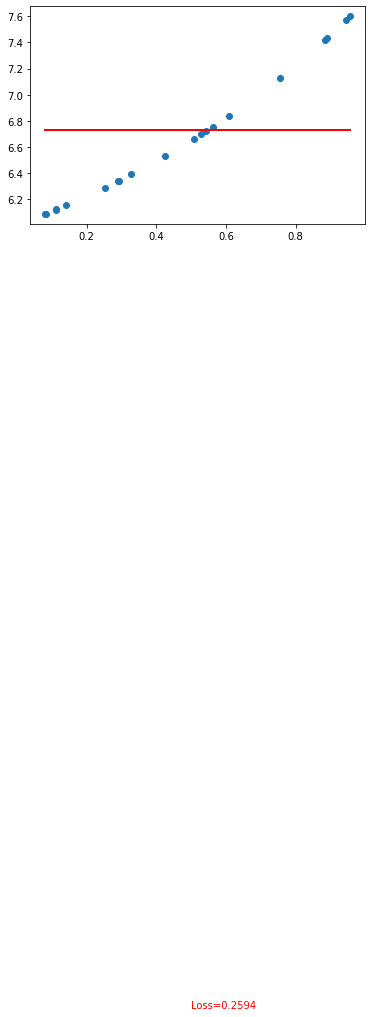

Epoch: 1/1... Step: 2500... Loss: 0.277862... Val Loss: 0.239636


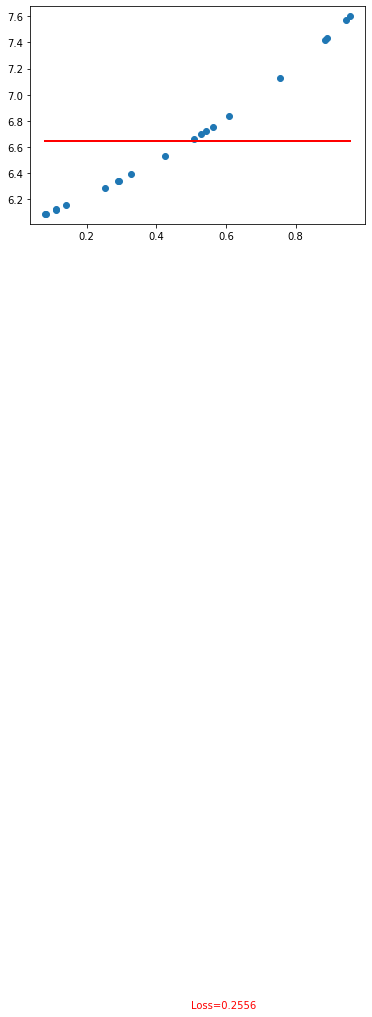

Epoch: 1/1... Step: 2600... Loss: 0.274866... Val Loss: 0.244630


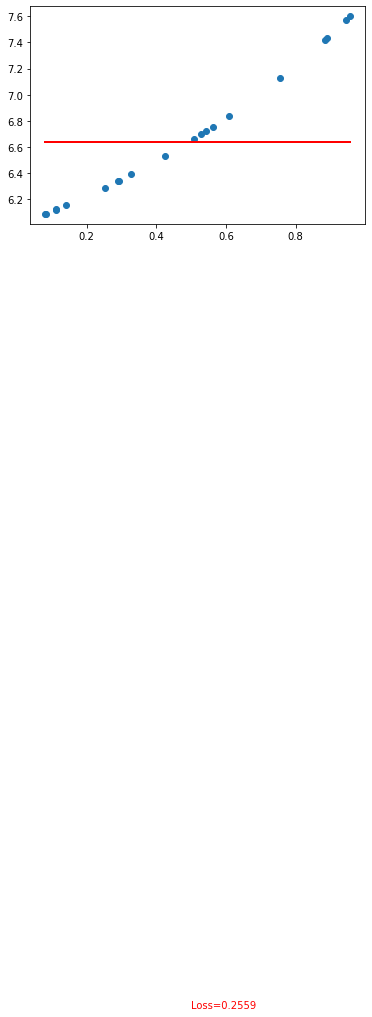

Epoch: 1/1... Step: 2700... Loss: 0.277353... Val Loss: 0.245715


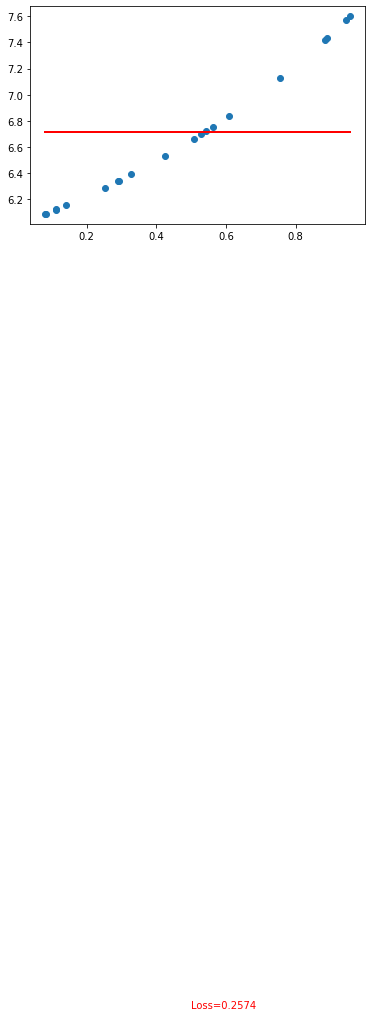

Epoch: 1/1... Step: 2800... Loss: 0.232171... Val Loss: 0.239589


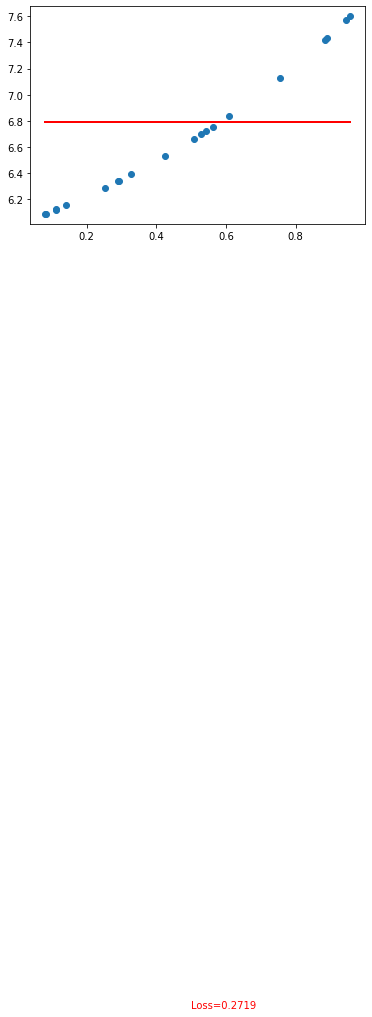

Epoch: 1/1... Step: 2900... Loss: 0.208422... Val Loss: 0.245152


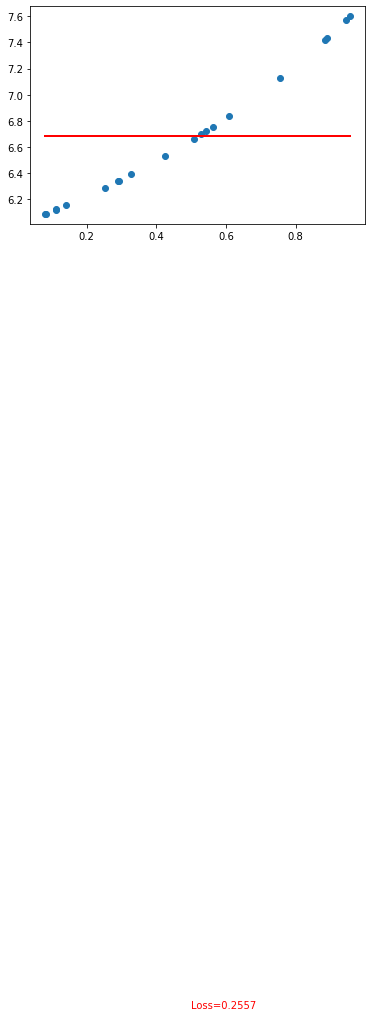

Epoch: 1/1... Step: 3000... Loss: 0.301120... Val Loss: 0.240713


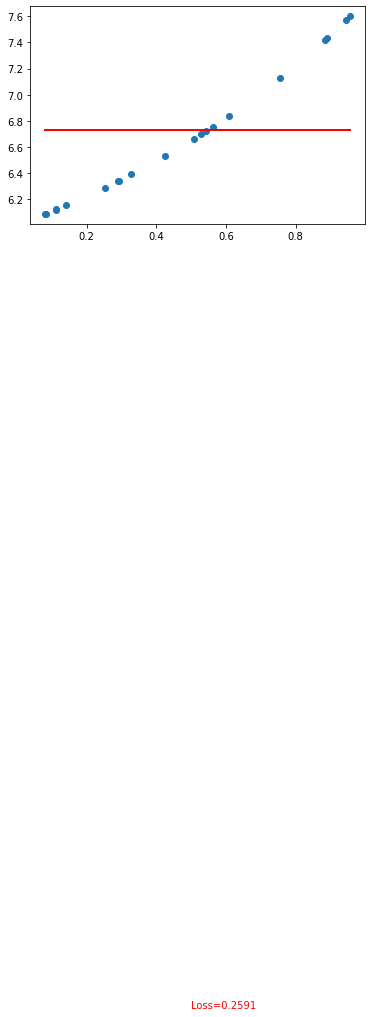

Epoch: 1/1... Step: 3100... Loss: 0.262553... Val Loss: 0.239596


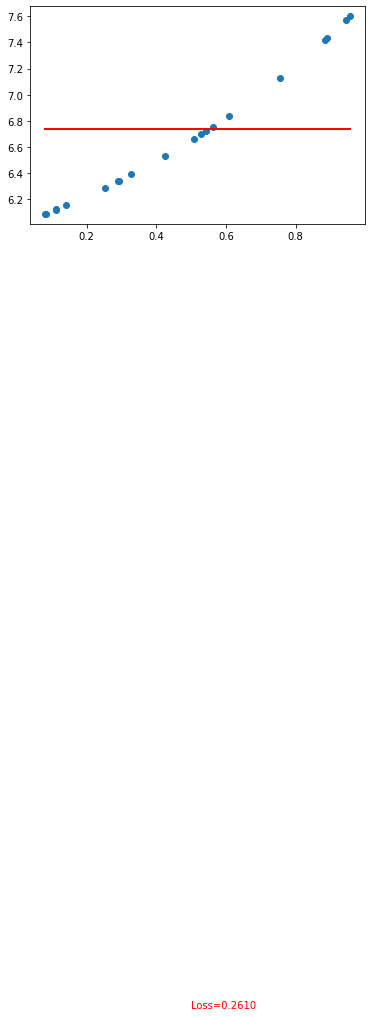

Epoch: 1/1... Step: 3200... Loss: 0.298468... Val Loss: 0.239987


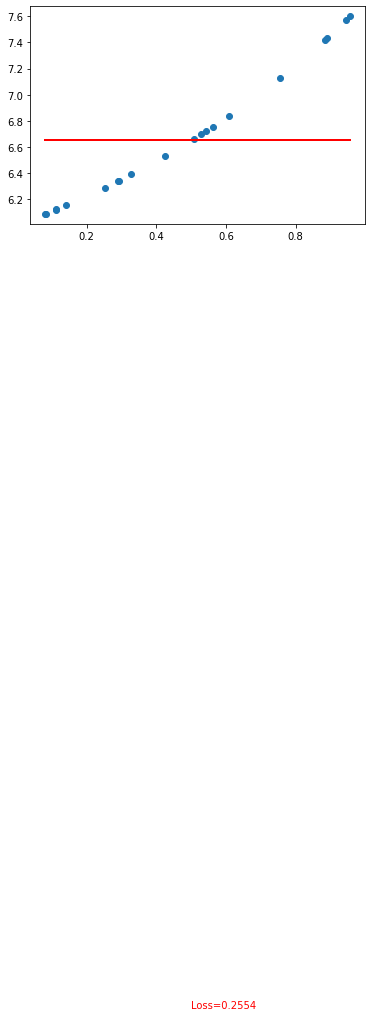

Epoch: 1/1... Step: 3300... Loss: 0.189244... Val Loss: 0.243983


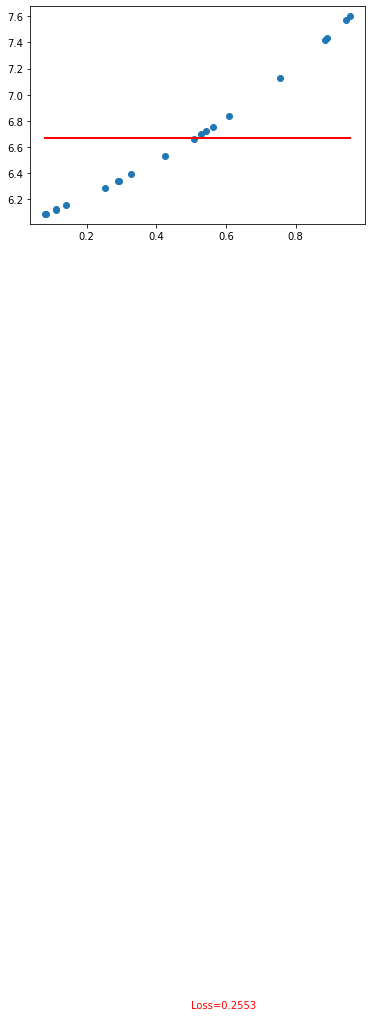

Epoch: 1/1... Step: 3400... Loss: 0.235566... Val Loss: 0.242466


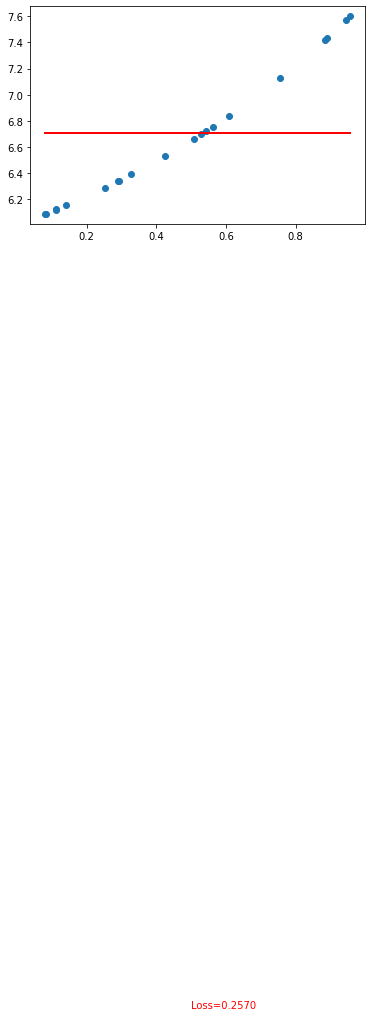

Epoch: 1/1... Step: 3500... Loss: 0.278574... Val Loss: 0.239704


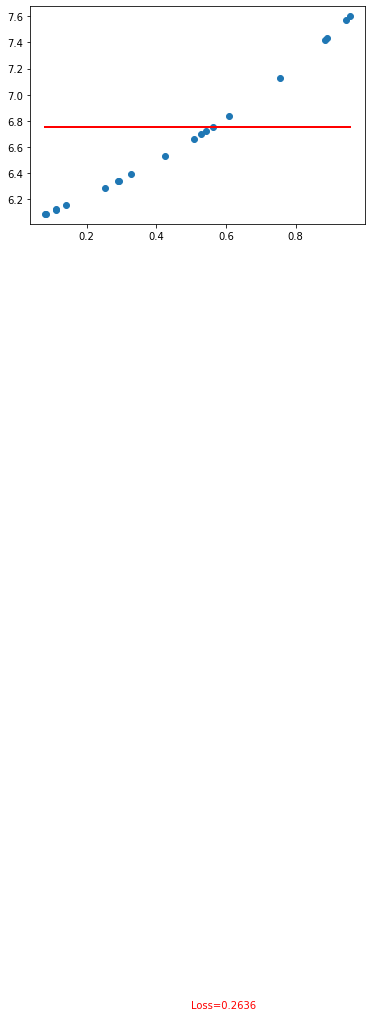

Epoch: 1/1... Step: 3600... Loss: 0.240251... Val Loss: 0.240922


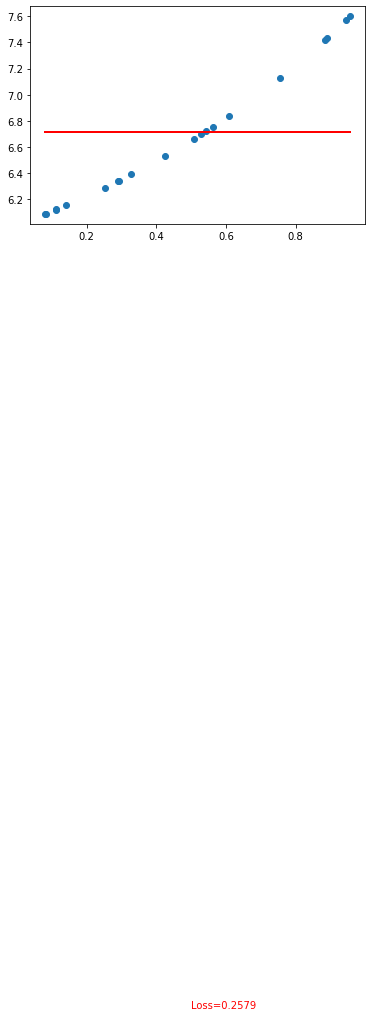

Epoch: 1/1... Step: 3700... Loss: 0.230591... Val Loss: 0.239543


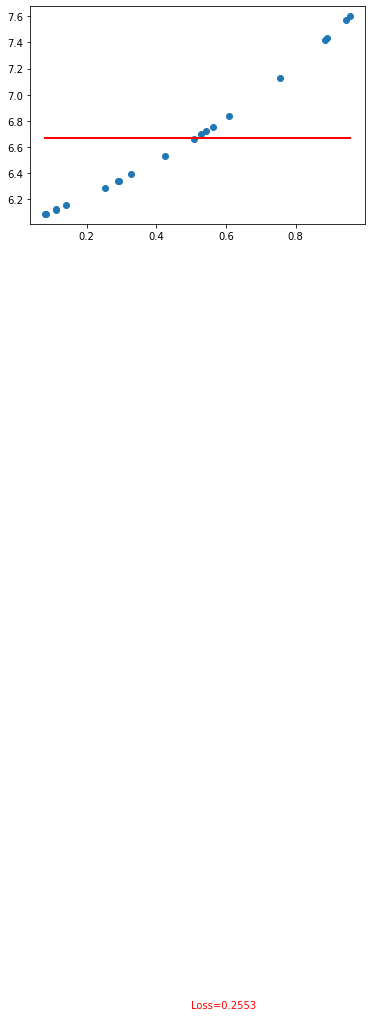

Epoch: 1/1... Step: 3800... Loss: 0.144574... Val Loss: 0.241724


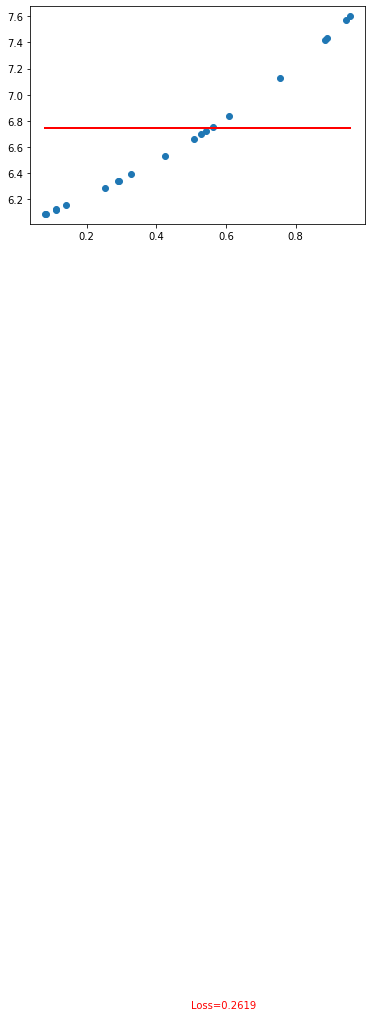

Epoch: 1/1... Step: 3900... Loss: 0.255570... Val Loss: 0.240291


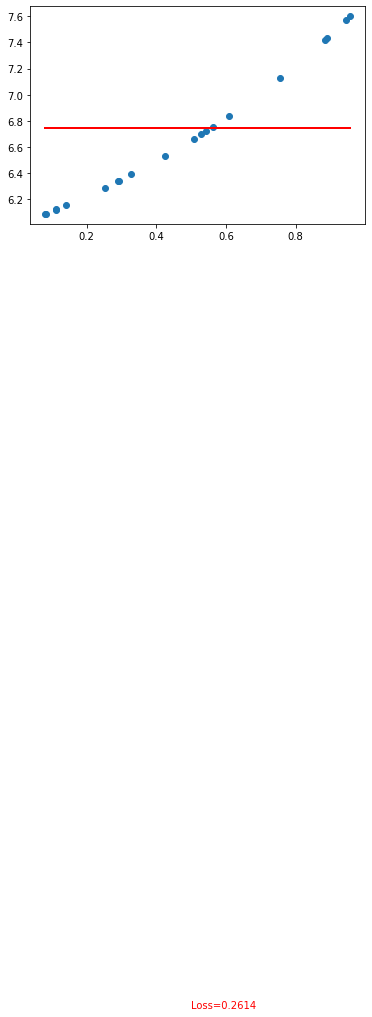

Epoch: 1/1... Step: 4000... Loss: 0.247697... Val Loss: 0.240130


In [9]:
for e in range(epochs):
    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        # if training on gpu
        inputs, labels = inputs.to(device), labels.to(device)

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        # x.size() -> [batch_size]
        batch_size = inputs.size(0)
        # IMPORTANT - change the dimensions of x before it enters the NN, batch size must always be first
        x = inputs.unsqueeze(0)         # x.size() -> [1, batch_size]
        x = x.view(batch_size, -1)      # x.size() -> [batch_size, 1]
        predictions = net(x)

        # calculate the loss and perform backprop
        loss = loss_func(predictions.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_losses = []
            net.eval()
            print_flag = True
            for inputs, labels in valid_loader:
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                if print_flag:
                  inputs, labels = zip(*sorted(zip(inputs.numpy(), labels.numpy())))
                  inputs = torch.from_numpy(np.asarray(inputs))
                  labels = torch.from_numpy(np.asarray(labels))
                inputs, labels = inputs.to(device), labels.to(device)
                 

                # get the output from the model
                # x.size() -> [batch_size]
                batch_size = inputs.size(0)
                # IMPORTANT - change the dimensions of x before it enters the NN, batch size must always be first
                x = inputs.unsqueeze(0)    # x.size() -> [1, batch_size]
                x = x.view(batch_size, -1) # x.size() -> [batch_size, 1]
                val_predictions = net(x)
                val_loss = loss_func(val_predictions.squeeze(), labels.float())

                val_losses.append(val_loss.item())
                if print_flag:
                  print_flag = False
                  # plot and show learning process
                  fig = plt.figure()
                  ax = fig.add_subplot(111)
                  ax.cla()
                  ax.scatter(inputs.cpu().data.numpy(), labels.cpu().data.numpy())
                  ax.plot(inputs.cpu().data.numpy(), val_predictions.cpu().data.numpy(), 'r-', lw=2)
                  ax.text(0.5, 0, 'Loss=%.4f' % np.mean(val_losses), fontdict={'size': 10, 'color':  'red'})
                  plt.pause(0.1)
                  ax.clear()

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
plt.show()

### Part 3 - More About AUTOGRAD: Automatic Differentiation

As you have seen in the regression model above, tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing.

During our training we have used AUTOGRAD methods to update our Neural Net. Lets discuss about that in more details.

***torch.Tensor*** is the central class of the package. If you set its attribute ***.requires_grad*** as True, it starts to track all operations on it. When you finish your computation you can call ***.backward()*** and have all the gradients computed automatically. The gradient for this tensor will be accumulated into .grad attribute.

To stop a tensor from tracking history, you can call ***.detach()*** to detach it from the computation history, and to prevent future computation from being tracked.

In [ ]:
import torch

# Notice the 'requires_grad'
x = torch.ones(2, 2, requires_grad=True)
print(x)

y = x + 2
print(y)

print(y.grad_fn)


In [ ]:
# Notice how the tensors follow mathamtical operations
z = y * y * 3
out = z.mean()

print(z)
print(out)

More on require grad

In [ ]:
a = torch.randn(3, 2)
a = ((a * 3) - (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

### Lets see how easy it is to calculate the gradients:

In [ ]:
b.backward()
# print gradients d(out)/dx
print(a.grad)

## A bit more on pytorch datasets

A custom Dataset class must implement three functions: \_\_init__, \_\_len__, and \_\_getitem__.

In [2]:
import torch
from torch.utils.data import Dataset
import pandas as pd

In [3]:
class ClassificationDataset(Dataset):

    def __init__(self, file_path):
        # Read data
        self.file_path = file_path
        data = pd.read_csv(self.file_path)

        # Split to sentences and labels
        self.sentences = data['reviewText'].tolist()
        self.labels = data['label'].tolist()

    def __getitem__(self, item):
        cur_sen = self.sentences[item]
        label = self.labels[item]
        data = {"sentences": cur_sen, "labels": label}
        return data

    def __len__(self):
        return len(self.sentences)

In [4]:
dataset = ClassificationDataset('./amazon_sa/train.csv')

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Much of the code above is adjusted from  <a href="https://github.com/udacity">Udacity tutorials</a>
* By <a href="https://github.com/eyalbd2">Eyal Ben David</a> and <a href="https://github.com/nadavo">Nadav Oved </a>